### Colab Has tested and awkward performanced was witnessed

#### First! how to transform an image and how to display transformed images?
transforming images is used to enhance robustness of the model

In [61]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [62]:
path = 'D:\sandbox\computer-vision\data\FAIR-FACE\\fairface-img-margin025-trainval\\train\\1.jpg'

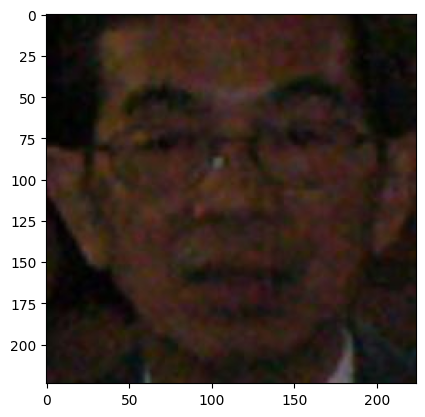

In [63]:
im = cv2.imread(path)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [68]:
from torchvision import transforms as T
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(100),
    T.ColorJitter(brightness=(0.95,1.05),
        contrast=(0.95,1.05),
        saturation=(0.95,1.05),
        hue=0.05),
    T.RandomAffine(30, translate=(0.6,0.1)),
    T.ToTensor()
])

In [69]:
transformed = trn_tfms(im)

In [70]:
transformed

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.2745, 0.2902, 0.2941],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1961, 0.1922, 0.1882],
         [0.0000, 0.0000, 0.0000,  ..., 0.2275, 0.2039, 0.1804],
         [0.0000, 0.0000, 0.0000,  ..., 0.2431, 0.2196, 0.2039]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1373, 0.1373, 0.1255],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1294, 0.1333, 0.1255],
         [0.0000, 0.0000, 0.0000,  ..., 0.1373, 0.1294, 0.1373],
         [0.0000, 0.0000, 0.0000,  ..., 0.1412, 0.1333, 0.1373]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1176, 0.1294, 0.

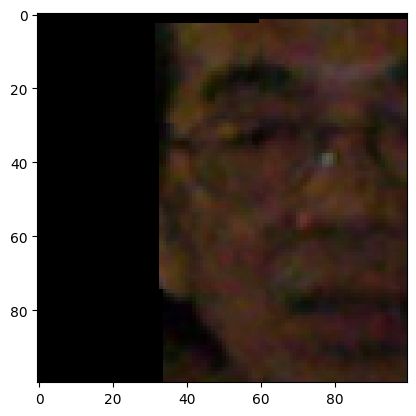

In [71]:
plt.imshow(transformed.permute(1,2,0).float().to('cpu'))

Start processing Cell Images

In [39]:
from random import randint
import logging
import torch
from torchvision import transforms as T
from torch.utils.data import Dataset,DataLoader
import cv2,numpy as np ,logging,os,matplotlib.pyplot as plt
from glob import glob
from torch import nn
from pathlib import Path
from torchsummary import summary
%matplotlib inline

# Set up the basic configuration for logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.FileHandler('app.log'), logging.StreamHandler()])

# Create a logger
logger = logging.getLogger(__name__)

2025-01-31 16:57:12,349 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [142]:
id2int = {'Parasitized': 0, 'Uninfected': 1}
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(.95,1.05),contrast=(.95,1.05),saturation=(.95,1.05),hue=0.05),
    T.RandomAffine(5,translate=(0.01,.05)),
    T.ToTensor(),
    T.Normalize(std=[.5,.5,.5],mean=[.5,.5,.5])
])

In [143]:
val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]),
    ]
)

In [144]:
class MalariaImages(Dataset):
    def __init__(self,files,transform=None):
        self.files = files
        self.transform = transform
        logger.debug(len(self))

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        file = self.files[index]
        categorized_class = id2int[Path(file).parent.name]
        img = cv2.imread(file)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        return img, categorized_class

    def choose(self):
        return self.files[randint(len(self.files))]
    
    def collate_fn(self,batch):
        _imgs,_classes =  list(zip(*batch))
        if self.transform:
            imgs = [self.transform(_img)[None] for _img in _imgs]
            classes = [torch.tensor(_class)[None] for _class in _classes]
            imgs ,classes = [torch.cat(i) for i in (imgs,classes)]
            return imgs,classes,_imgs


In [145]:
all_files = glob('data/cell_images/**/*.png')
len(all_files[:100])

100

In [146]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = glob('data/cell_images/*/*.png')

np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files[:750], random_state=1)

trn_ds = MalariaImages(trn_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)

trn_dl = DataLoader(trn_ds, 32, shuffle=True,collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False,collate_fn=val_ds.collate_fn)

2025-01-31 19:10:15,708 - DEBUG - 562
2025-01-31 19:10:15,712 - DEBUG - 188


In [147]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2)
    )
class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self,x):
        return self.model(x)
    
    def compute_metrics(self,preds,targets):
        loss = self.loss_fn(preds,targets)
        acc = (torch.max(preds,1)[1] == targets).float().mean()  #IMPORTANT, INDICE IS IMPORTANT TO US NOT VALUE!
        return loss,acc





In [148]:
def train_batch(model,data,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    image,label,_ = data #loos at the output of collate_fn not the output of getitem
    cat_pred = model(image)
    loss,acc = criterion(cat_pred,label)
    loss.backward()
    optimizer.step()
    return loss,acc


@torch.no_grad
def validate_batch(model,data,criterion):
    model.eval()
    image,label,_ = data #loos at the output of collate_fn not the output of getitem
    cat_pred = model(image)
    loss,acc = criterion(cat_pred,label)
    return loss,acc

In [149]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 8
for ex in range(n_epochs):
    N = len(trn_dl)
    logger.info(f'epoch number {ex}')
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        logger.debug(f'train loss = {loss},train accuracy is {acc}')
    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        logger.debug(f'val loss = {loss},val accuracy is {acc}')
if2ifmap = nn.Sequential(*list(model.model[:5].children())+list(model.model[5][2].children()))

2025-01-31 19:10:30,674 - INFO - epoch number 0


2025-01-31 19:10:35,564 - DEBUG - train loss = 0.715739369392395,train accuracy is 0.59375
2025-01-31 19:10:39,281 - DEBUG - train loss = 0.7936130166053772,train accuracy is 0.625
2025-01-31 19:10:43,315 - DEBUG - train loss = 0.6921052932739258,train accuracy is 0.46875
2025-01-31 19:10:46,812 - DEBUG - train loss = 0.5985235571861267,train accuracy is 0.71875
2025-01-31 19:10:50,427 - DEBUG - train loss = 0.8131241798400879,train accuracy is 0.5
2025-01-31 19:10:53,964 - DEBUG - train loss = 0.7036780118942261,train accuracy is 0.59375
2025-01-31 19:10:58,021 - DEBUG - train loss = 0.6844109892845154,train accuracy is 0.53125
2025-01-31 19:11:01,653 - DEBUG - train loss = 0.7043644785881042,train accuracy is 0.53125
2025-01-31 19:11:05,382 - DEBUG - train loss = 0.6943001747131348,train accuracy is 0.5625
2025-01-31 19:11:10,040 - DEBUG - train loss = 0.6511609554290771,train accuracy is 0.5
2025-01-31 19:11:13,795 - DEBUG - train loss = 0.7132540941238403,train accuracy is 0.59375


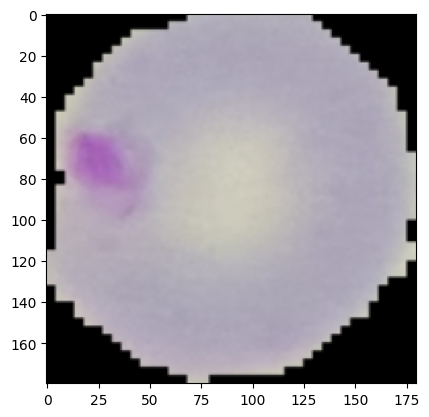

In [150]:
x,y,z = next(iter(val_dl))
image = cv2.resize(z[2],(180,180))
plt.imshow(image)

In [151]:
def im2gradCAM(x):
    model.eval()
    #get models prediction
    logits = model(x)
    pred = logits.max(-1)[-1]


    activations = if2ifmap(x)
    #compute gradient with respect to model's most confident output
    model.zero_grad()
    logits[0,pred].backward(retain_graph=True)

    pooled_grads = model.model[-6][1].weight.grad.data.mean((0,2,3)) # since we are dealing with output_channel * input_channel * wight * height
                                                      # this gives us mean over each input channel

    # multiply each activation map with
    # corresponding gradient average
    # iterate over each input channel
    for i in range(activations.shape[1]):
        activations[:,i,:,:]*=pooled_grads[i]


    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap =torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [152]:
SZ = 128
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

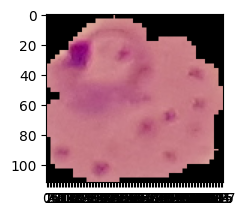

In [153]:
import matplotlib.ticker as mticker

img ,_ = val_ds.__getitem__(5)

plt.subplot(211)
plt.imshow(img)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

torch.Size([4, 4])
torch.Size([4, 4])
torch.Size([4, 4])
torch.Size([4, 4])
torch.Size([4, 4])
torch.Size([4, 4])
torch.Size([4, 4])
torch.Size([4, 4])
torch.Size([4, 4])
torch.Size([4, 4])


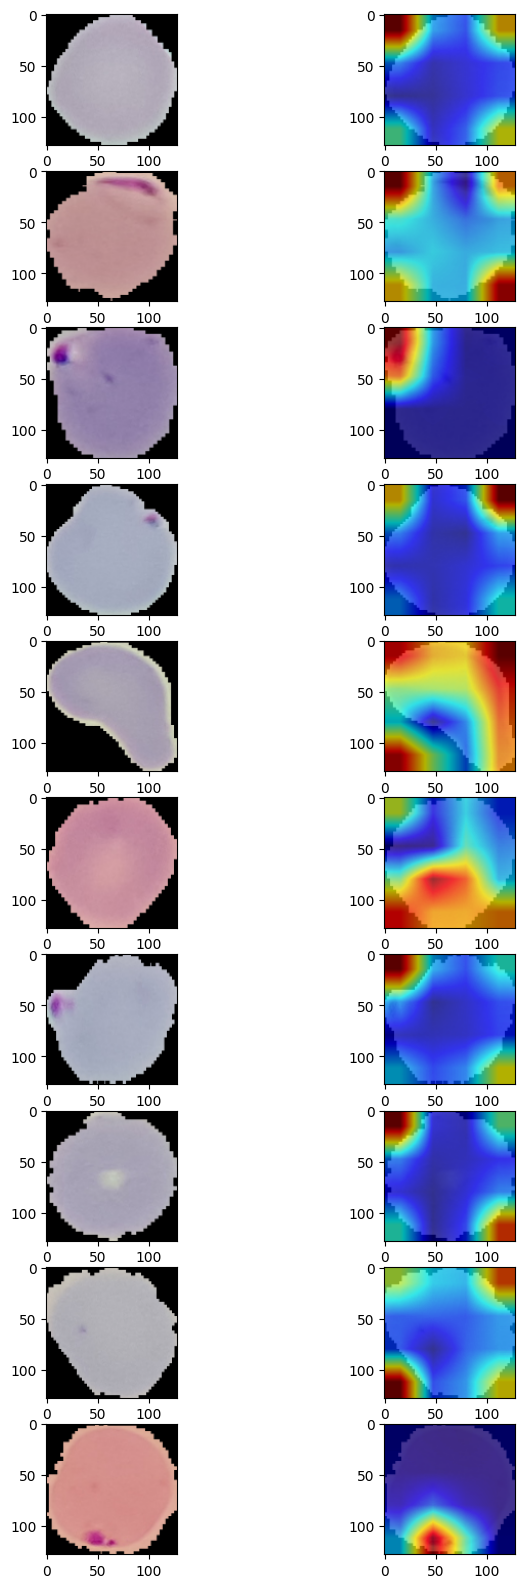

<Figure size 640x480 with 0 Axes>

In [154]:
import matplotlib.ticker as mticker



N = 10
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
fig, axs = plt.subplots(N, 2,figsize=(8,20))

x,y,z = next(iter(_val_dl))
for i in range(N):
    ax = axs[i]
    image = cv2.resize(z[i], (SZ,SZ))
    heatmap, pred = im2gradCAM(x[i:i+1])
    print(heatmap.shape)
    # if(pred=='Uninfected'):
    #     continue
    heatmap = upsampleHeatmap(heatmap, image)
    ax[0].imshow(image)
    ax[1].imshow(heatmap)

plt.show()
plt.tight_layout()

In [23]:
a = [torch.tensor([1,3,5]),torch.tensor([5,7,9])]
b = [torch.tensor([2,4]),torch.tensor([6,8])]

fo = [torch.cat(i) for i in (a,b)]
fo

[tensor([1, 3, 5, 5, 7, 9]), tensor([2, 4, 6, 8])]

## Data Augmentation And Batch Normalization

In [95]:
import pandas as pd
from torchvision import transforms as T
from pathlib import Path
import cv2,numpy as np
import torch,torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from glob import glob
from torch import optim
import logging
import matplotlib.pyplot as plt
%matplotlib inline
# Set up the basic configuration for logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.FileHandler('app.log'), logging.StreamHandler()])
logger = logging.getLogger(__name__)

2025-02-06 19:51:35,664 - DEBUG - CACHEDIR=C:\Users\MASOUD\.matplotlib
2025-02-06 19:51:35,727 - DEBUG - Using fontManager instance from C:\Users\MASOUD\.matplotlib\fontlist-v330.json
2025-02-06 19:51:38,366 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-02-06 19:51:38,398 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [64]:
base_path = './data/GTSRB/'


classIds = pd.read_csv( base_path + 'signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

In [65]:
classIds

{'0': 'Speed limit (20km/h)',
 '1': 'Speed limit (30km/h)',
 '2': 'Speed limit (50km/h)',
 '3': 'Speed limit (60km/h)',
 '4': 'Speed limit (70km/h)',
 '5': 'Speed limit (80km/h)',
 '6': 'End of speed limit (80km/h)',
 '7': 'Speed limit (100km/h)',
 '8': 'Speed limit (120km/h)',
 '9': 'No passing',
 '10': 'No passing for vechiles over 3.5 metric tons',
 '11': 'Right-of-way at the next intersection',
 '12': 'Priority road',
 '13': 'Yield',
 '14': 'Stop',
 '15': 'No vechiles',
 '16': 'Vechiles over 3.5 metric tons prohibited',
 '17': 'No entry',
 '18': 'General caution',
 '19': 'Dangerous curve to the left',
 '20': 'Dangerous curve to the right',
 '21': 'Double curve',
 '22': 'Bumpy road',
 '23': 'Slippery road',
 '24': 'Road narrows on the right',
 '25': 'Road work',
 '26': 'Traffic signals',
 '27': 'Pedestrians',
 '28': 'Children crossing',
 '29': 'Bicycles crossing',
 '30': 'Beware of ice/snow',
 '31': 'Wild animals crossing',
 '32': 'End of all speed and passing limits',
 '33': 'Turn 

In [ ]:
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ColorJitter(brightness=(0.8,1.2),
    contrast=(0.8,1.2),
    saturation=(0.8,1.2),
    hue=0.25),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]),
])
val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]),
])

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' on line 9 (39253843.py, line 13)

In [110]:
class GTSRB(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = Path(fpath).parent.name
        img = cv2.imread(fpath)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        return img, classIds[clss]
    
    def choose(self):
        return self[randint(len(self))]
    
    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs =[self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

In [111]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = glob(base_path+'/Train/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)
trn_ds = GTSRB(trn_files[:1000], transform=trn_tfms)
val_ds = GTSRB(val_files[:100], transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)
import torchvision.models as models
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
        convBlock(3, 64),
        convBlock(64, 64),
        convBlock(64, 128),
        convBlock(128, 64),
        nn.Flatten(),
        nn.Linear(256, 256),
        nn.Dropout(0.2),
        nn.ReLU(inplace=True),
        nn.Linear(256, len(id2int))
    )
        self.loss_fn = nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.model(x)
    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc =(torch.max(preds, 1)[1]==targets).float().mean()
        return ce_loss, acc

2025-02-06 20:09:12,181 - INFO - 1000
2025-02-06 20:09:12,183 - INFO - 100


In [112]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

In [113]:
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [114]:
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 15
logger.info(f'number of epochs :{n_epochs}')
epoch_losses, epoch_acc = [],[]
epoch_val_losses, epoch_val_acc = [],[]
for ex in range(n_epochs):
    N = len(trn_dl)
    logger.debug(N)
    train_losses, train_acc = [],[]
    val_losses, val_acc = [],[]

    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        train_losses.append(loss)
        train_acc.append(acc)

    epoch_losses.append(np.mean(loss))
    epoch_acc.append(np.mean(train_acc))
    logger.info(f'{ex+(bx+1)/N},trn_loss={np.mean(loss)}, trn_acc={np.mean(train_acc)} ')

    N = len(val_dl)

    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        val_losses.append(loss)
        val_acc.append(acc)
    
    epoch_val_acc.append(np.mean(val_acc))
    epoch_val_losses.append(np.mean(val_losses))

    logger.info(f'{ex+(bx+1)/N},val_loss={np.mean(val_losses)}, val_acc={np.mean(val_acc)} ')

    if ex > 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

2025-02-06 20:09:18,725 - INFO - number of epochs :15
2025-02-06 20:09:18,729 - DEBUG - 32


2025-02-06 20:09:36,336 - INFO - 1.0,trn_loss=3.5613210201263428, trn_acc=0.10546875 
2025-02-06 20:09:38,061 - INFO - 1.0,val_loss=3.6796571612358093, val_acc=0.0703125 
2025-02-06 20:09:38,063 - DEBUG - 32
2025-02-06 20:09:44,990 - INFO - 2.0,trn_loss=2.745851755142212, trn_acc=0.1875 
2025-02-06 20:09:45,365 - INFO - 2.0,val_loss=3.700080096721649, val_acc=0.1328125 
2025-02-06 20:09:45,368 - DEBUG - 32
2025-02-06 20:09:51,829 - INFO - 3.0,trn_loss=2.4221858978271484, trn_acc=0.2724609375 
2025-02-06 20:09:52,201 - INFO - 3.0,val_loss=3.464237868785858, val_acc=0.25 
2025-02-06 20:09:52,203 - DEBUG - 32
2025-02-06 20:09:58,465 - INFO - 4.0,trn_loss=1.913243055343628, trn_acc=0.341796875 
2025-02-06 20:09:58,833 - INFO - 4.0,val_loss=3.6842040419578552, val_acc=0.265625 
2025-02-06 20:09:58,837 - DEBUG - 32
2025-02-06 20:10:05,192 - INFO - 5.0,trn_loss=2.4768855571746826, trn_acc=0.4052734375 
2025-02-06 20:10:05,566 - INFO - 5.0,val_loss=3.814545750617981, val_acc=0.25 
2025-02-06 2

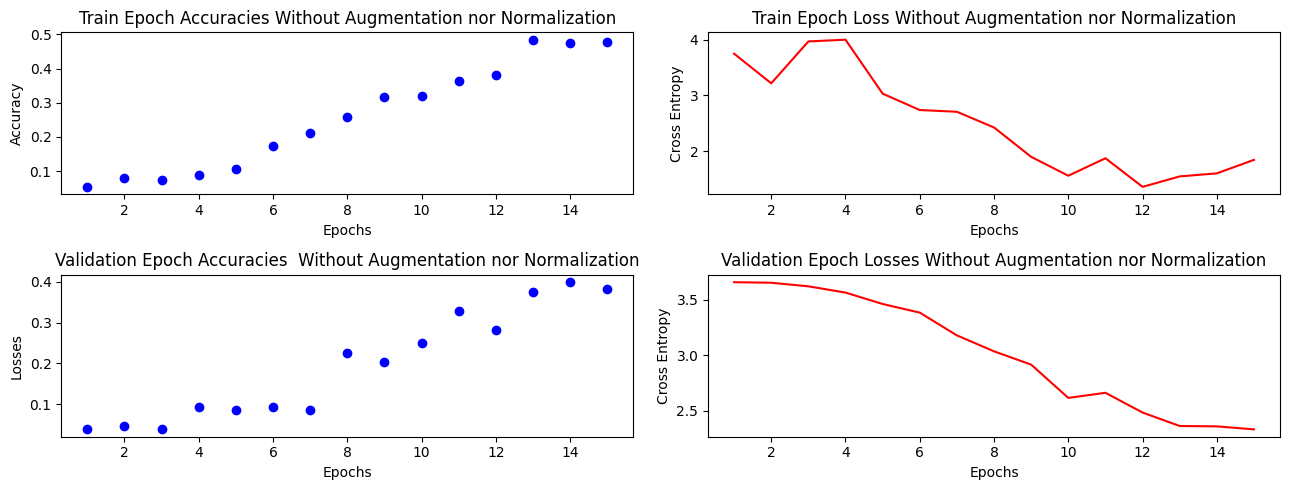

In [103]:
epochs = np.arange(1,(n_epochs+1))
fig,ax = plt.subplots(2,2,figsize=(13,5))
ax = ax.flat

ax[0].plot(epochs, epoch_acc, 'bo')
ax[1].plot(epochs, epoch_losses, 'r')

ax[0].set_xlabel('Epochs') ; ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy'); ax[1].set_ylabel('Cross Entropy')

ax[0].set_title('Train Epoch Accuracies Without Augmentation nor Normalization')
ax[1].set_title("Train Epoch Loss Without Augmentation nor Normalization")


ax[2].plot(epochs, epoch_val_acc, 'bo')
ax[3].plot(epochs, epoch_val_losses, 'r')
ax[2].set_xlabel('Epochs') ; ax[3].set_xlabel('Epochs')
ax[2].set_ylabel('Losses'); ax[3].set_ylabel('Cross Entropy')
ax[2].set_title('Validation Epoch Accuracies  Without Augmentation nor Normalization',)
ax[3].set_title('Validation Epoch Losses Without Augmentation nor Normalization')

fig.tight_layout()
plt.show()

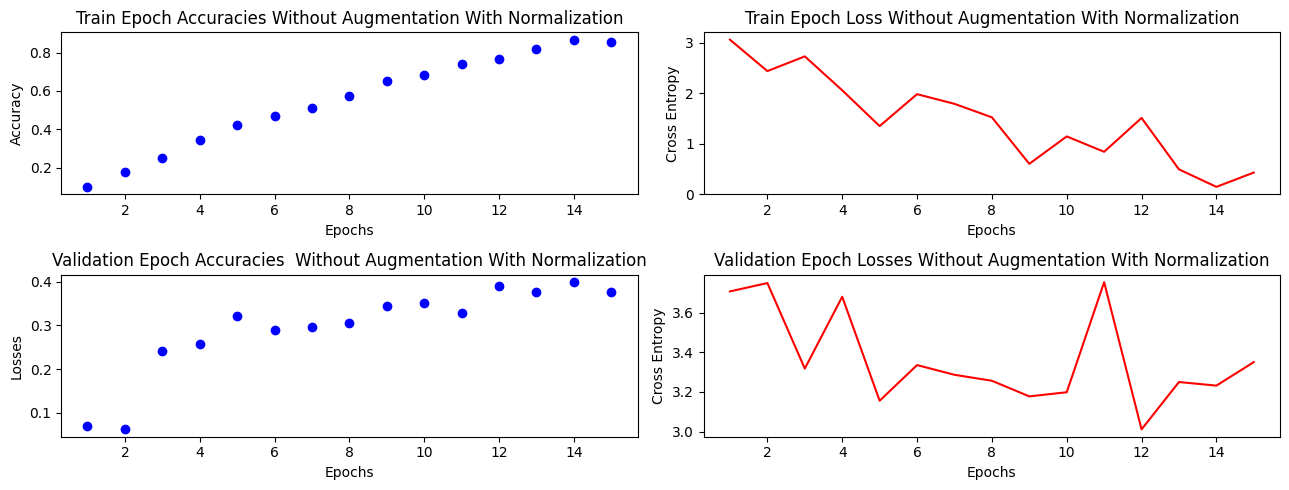

In [108]:
epochs = np.arange(1,(n_epochs+1))
fig,ax = plt.subplots(2,2,figsize=(13,5))
ax = ax.flat

ax[0].plot(epochs, epoch_acc, 'bo')
ax[1].plot(epochs, epoch_losses, 'r')

ax[0].set_xlabel('Epochs') ; ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy'); ax[1].set_ylabel('Cross Entropy')

ax[0].set_title('Train Epoch Accuracies Without Augmentation With Normalization')
ax[1].set_title("Train Epoch Loss Without Augmentation With Normalization")


ax[2].plot(epochs, epoch_val_acc, 'bo')
ax[3].plot(epochs, epoch_val_losses, 'r')
ax[2].set_xlabel('Epochs') ; ax[3].set_xlabel('Epochs')
ax[2].set_ylabel('Losses'); ax[3].set_ylabel('Cross Entropy')
ax[2].set_title('Validation Epoch Accuracies  Without Augmentation With Normalization',)
ax[3].set_title('Validation Epoch Losses Without Augmentation With Normalization')

fig.tight_layout()
plt.show()

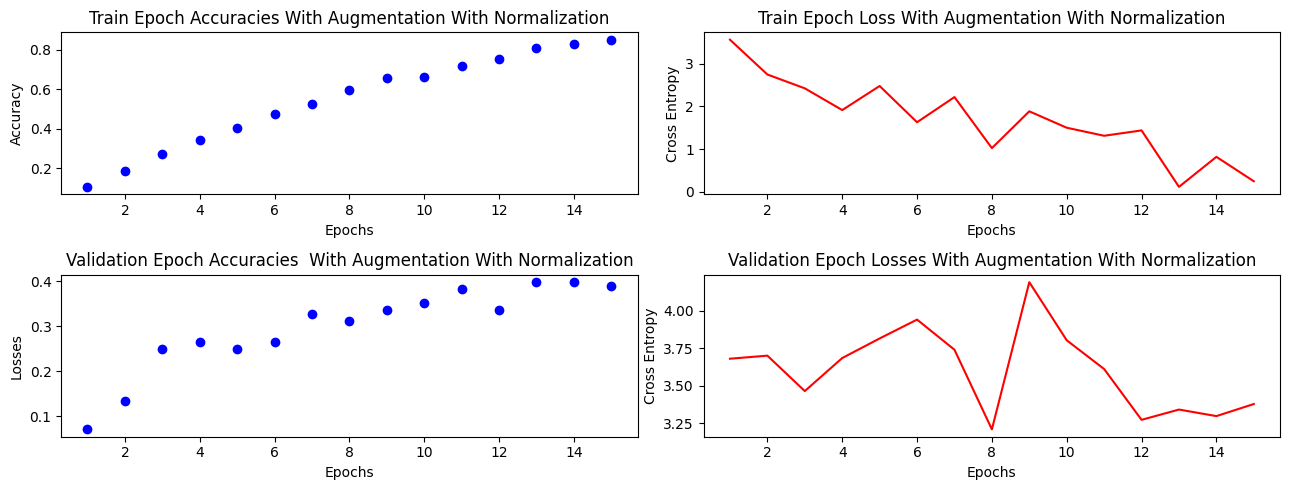

In [115]:
epochs = np.arange(1,(n_epochs+1))
fig,ax = plt.subplots(2,2,figsize=(13,5))
ax = ax.flat

ax[0].plot(epochs, epoch_acc, 'bo')
ax[1].plot(epochs, epoch_losses, 'r')

ax[0].set_xlabel('Epochs') ; ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy'); ax[1].set_ylabel('Cross Entropy')

ax[0].set_title('Train Epoch Accuracies With Augmentation With Normalization')
ax[1].set_title("Train Epoch Loss With Augmentation With Normalization")


ax[2].plot(epochs, epoch_val_acc, 'bo')
ax[3].plot(epochs, epoch_val_losses, 'r')
ax[2].set_xlabel('Epochs') ; ax[3].set_xlabel('Epochs')
ax[2].set_ylabel('Losses'); ax[3].set_ylabel('Cross Entropy')
ax[2].set_title('Validation Epoch Accuracies  With Augmentation With Normalization',)
ax[3].set_title('Validation Epoch Losses With Augmentation With Normalization')

fig.tight_layout()
plt.show()